In [1]:
import stt as st
import scanpy as sc
import anndata
import scvelo as scv

In [2]:
data_dir = '../data/'
adata = sc.read_h5ad(data_dir+"A549_TGFB1.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 3132 × 2000
    obs: 'Clusters', '_X', '_Y', 'batch', 'time', 'cell', 'inducer', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    obsm: 'X_pca'
    layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spliced', 'unspliced', 'variance_velocity', 'velocity'

In [4]:
sc.pp.neighbors(adata, n_neighbors = 20)
sc.tl.umap(adata)

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/pyemma/__init__.py:92: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.7, you have 2.5.6.
  .format(latest=latest, current=current), category=UserWarning)


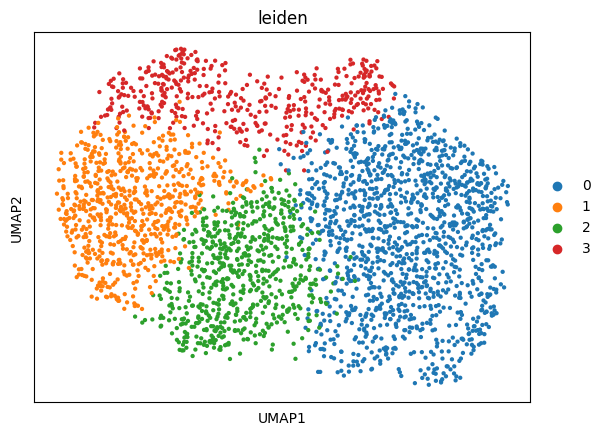

In [5]:
sc.tl.leiden(adata,resolution = 0.4)
sc.pl.umap(adata, color ='leiden')


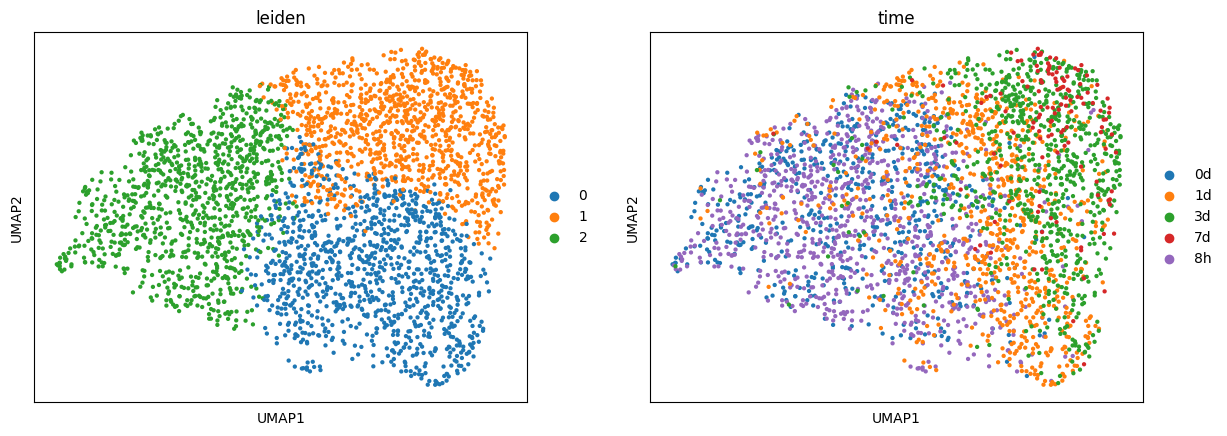

In [6]:
import numpy as np
import anndata
U = adata.layers['unspliced']
S = adata.layers['spliced']
if 'toarray' in dir(U):
    U = U.toarray()
    S = S.toarray()
X_all = np.concatenate((U,S),axis = 1)
adata_aggr = anndata.AnnData(X=X_all)
sc.tl.pca(adata_aggr, svd_solver='arpack')
sc.pp.neighbors(adata_aggr)
sc.tl.umap(adata_aggr)
sc.tl.leiden(adata_aggr,resolution = 0.2)
adata_aggr.obs['time'] = adata.obs['time'].values
sc.pl.umap(adata_aggr,color = ['leiden','time'])

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/3132 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


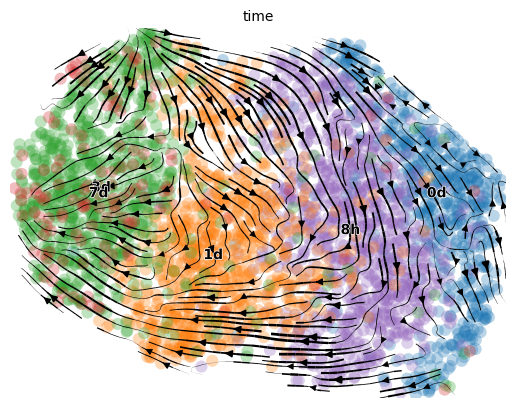

In [7]:
scv.tl.velocity(adata, mode = 'dynamical')
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, basis='umap', color=['time'])

In [8]:
adata.obs['attractor'] = adata.obs['time'].values
#adata.obsm['X_umap'] = adata_aggr.obsm['X_umap']
#adata_aggr = st.tl.dynamical_iteration(adata,n_states =3, n_iter = 15,  weight_connectivities = 0.5, n_components = 21, n_neighbors = 30,thresh_ms_gene = 0.2) 
adata_aggr = st.tl.dynamical_iteration(adata,n_states =3, n_iter = 15,  weight_connectivities = 0.5, n_components = 21, n_neighbors = 100,thresh_ms_gene = 0.2)

Mat Object: 1 MPI processes
  type: seqdense
1.0000000000000020e+00 -4.5070403465739019e-03 -6.7627083043229992e-03 -2.2830536231490461e-02 3.7990536741574502e-02 2.8466358271359016e-02 -4.7880002601958984e-03 -1.0273814504123457e-02 1.4066736007217768e-02 3.0431238565087997e-02 2.3266706964746472e-02 1.7970286556346297e-02 1.6043863415284208e-02 -1.5938310395931226e-02 8.7474504686720356e-03 2.5122082116070747e-02 4.4546830888565394e-03 1.7241234578163754e-02 9.0263202735314553e-03 -2.0667824823502479e-02 -4.1567744292099274e-03 
0.0000000000000000e+00 8.7184021980463988e-01 -5.8846692021201970e-02 3.5733098692036995e-02 -1.8854879530501769e-03 4.0744948565434470e-04 2.4423343620304298e-02 -2.2802552522064437e-02 -9.3273492216511562e-03 -2.0160674965465874e-02 -2.2315434294613894e-02 -3.0396763162220709e-03 1.3081385659488959e-02 2.4046658823267088e-02 -3.8192791596926970e-02 -7.1729032555790584e-03 -5.6934808351161117e-02 -2.0822296901961385e-02 6.1808772159735502e-03 6.6171387869422

/home/bingsanyu/1WORK/cwj/STT-release/example_notebooks/stt/tl/_dynamical_analysis.py:373: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sc_object_aggr.obs['entropy'] = adata.obs['entropy'].values


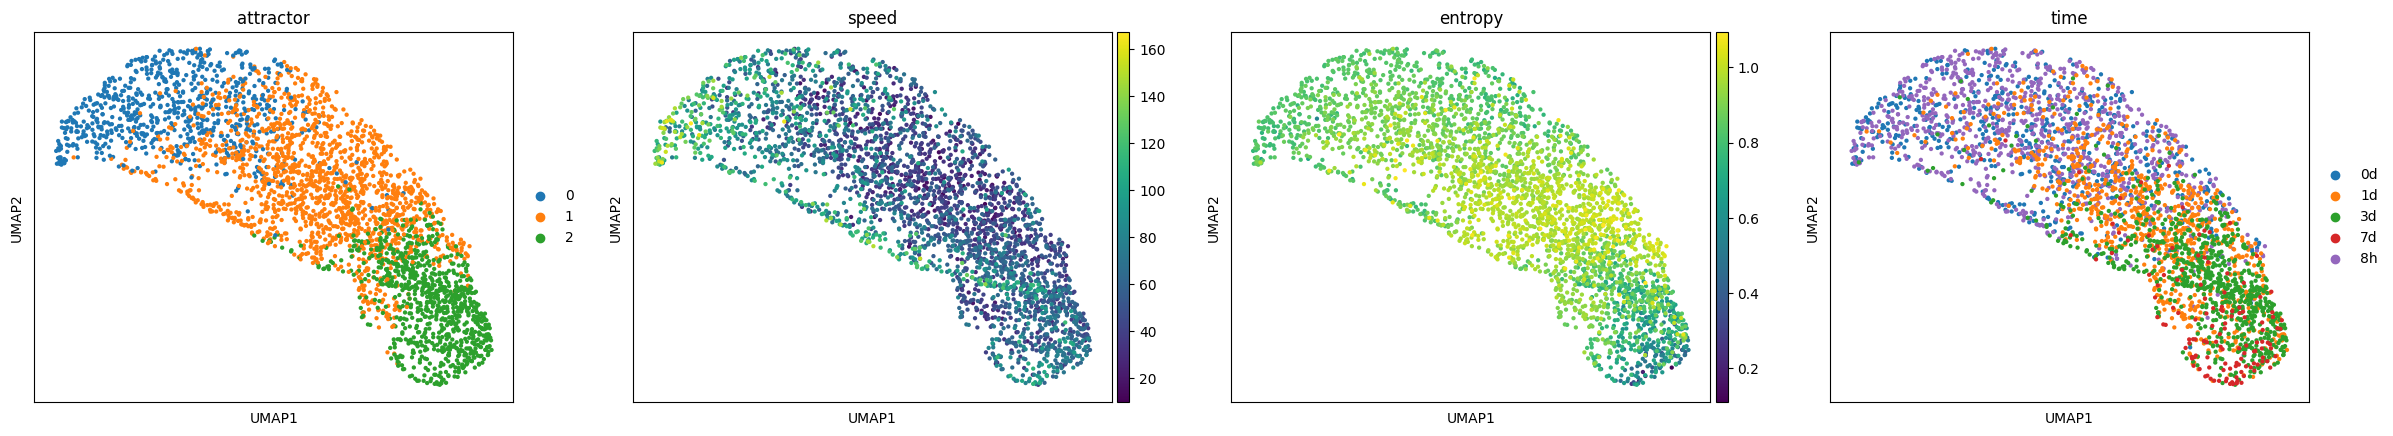

In [9]:
sc.pp.neighbors(adata_aggr, n_neighbors = 30)
sc.tl.umap(adata_aggr)
sc.pl.umap(adata_aggr,color = ['attractor','speed','entropy','time'])

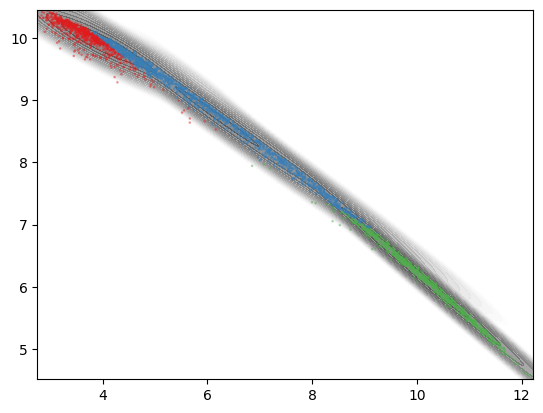

In [10]:
adata.obsm['X_umap'] = adata_aggr.obsm['X_umap']
st.tl.construct_landscape(adata,thresh_cal_cov = 0.5,scale_land = 0.9,scale_axis = 1, N_grid = 500)
st.pl.plot_landscape(adata,dim=2)

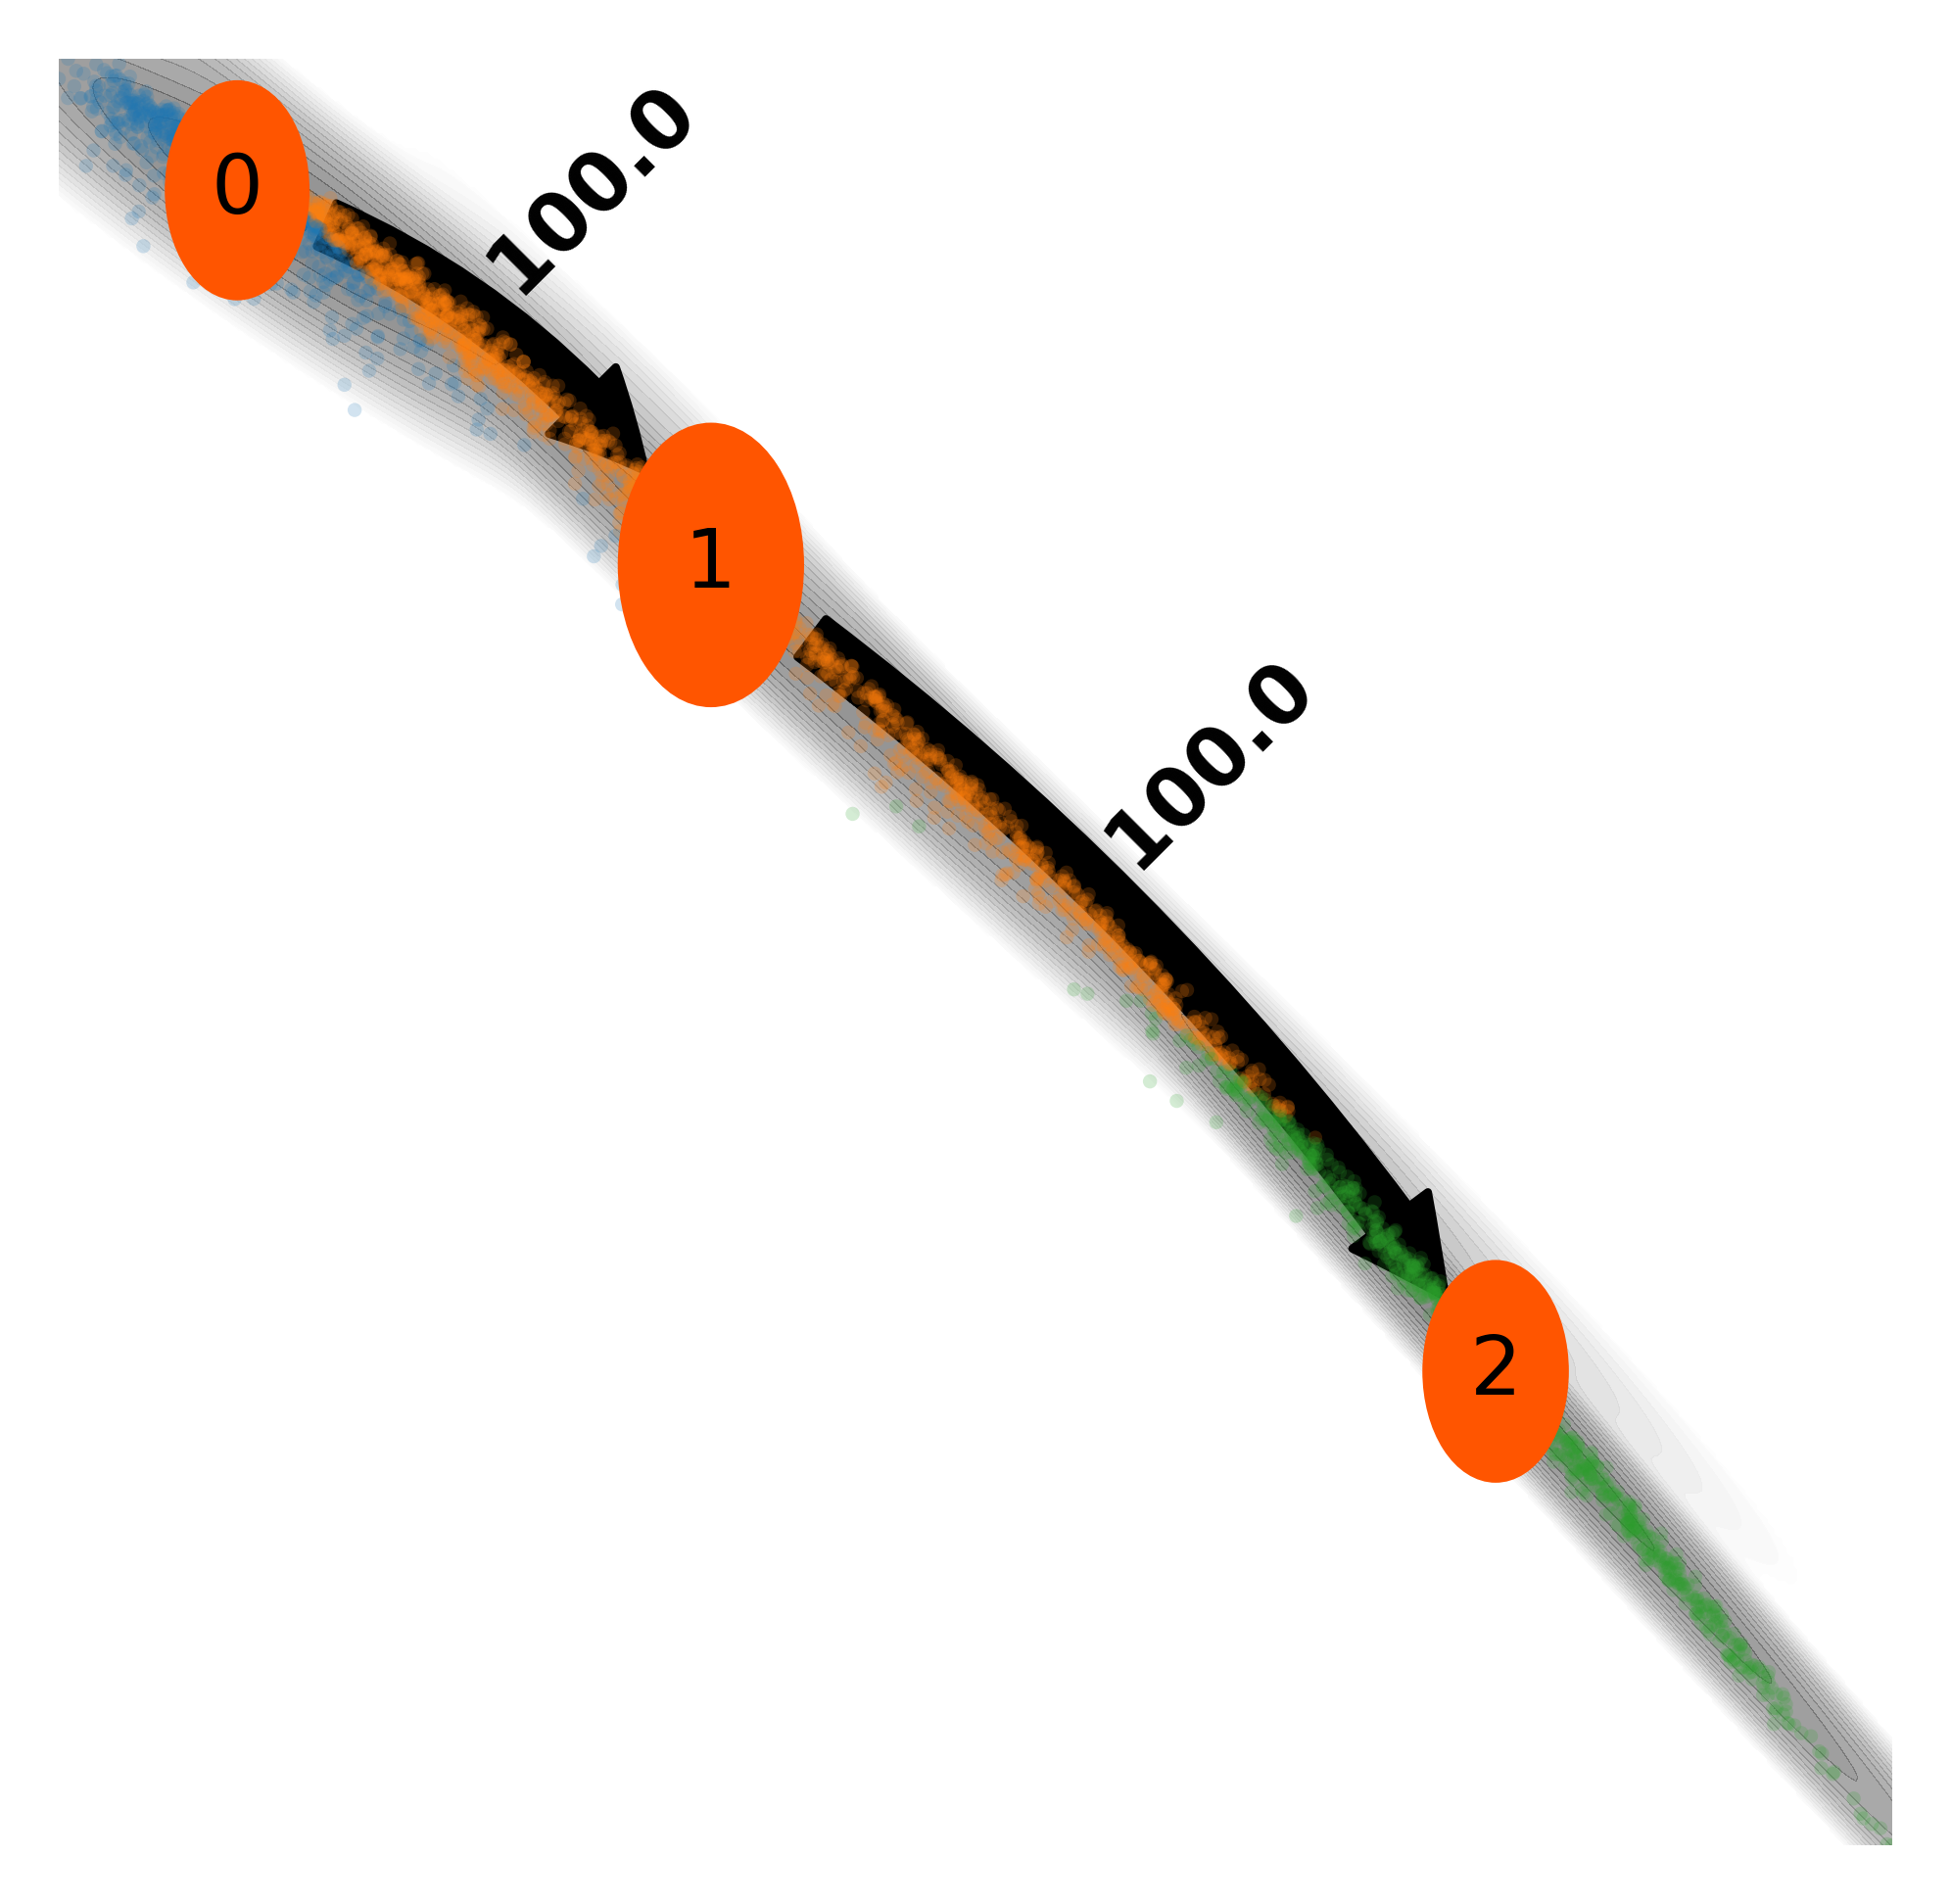

In [11]:
sc.set_figure_params(dpi=300,fontsize = 10)
st.pl.infer_lineage(adata,si=0, sf =2, method = 'MPPT',color_palette_name='tab10',alpha_point = 0.2,size_state = 1.0, size_text = 10)

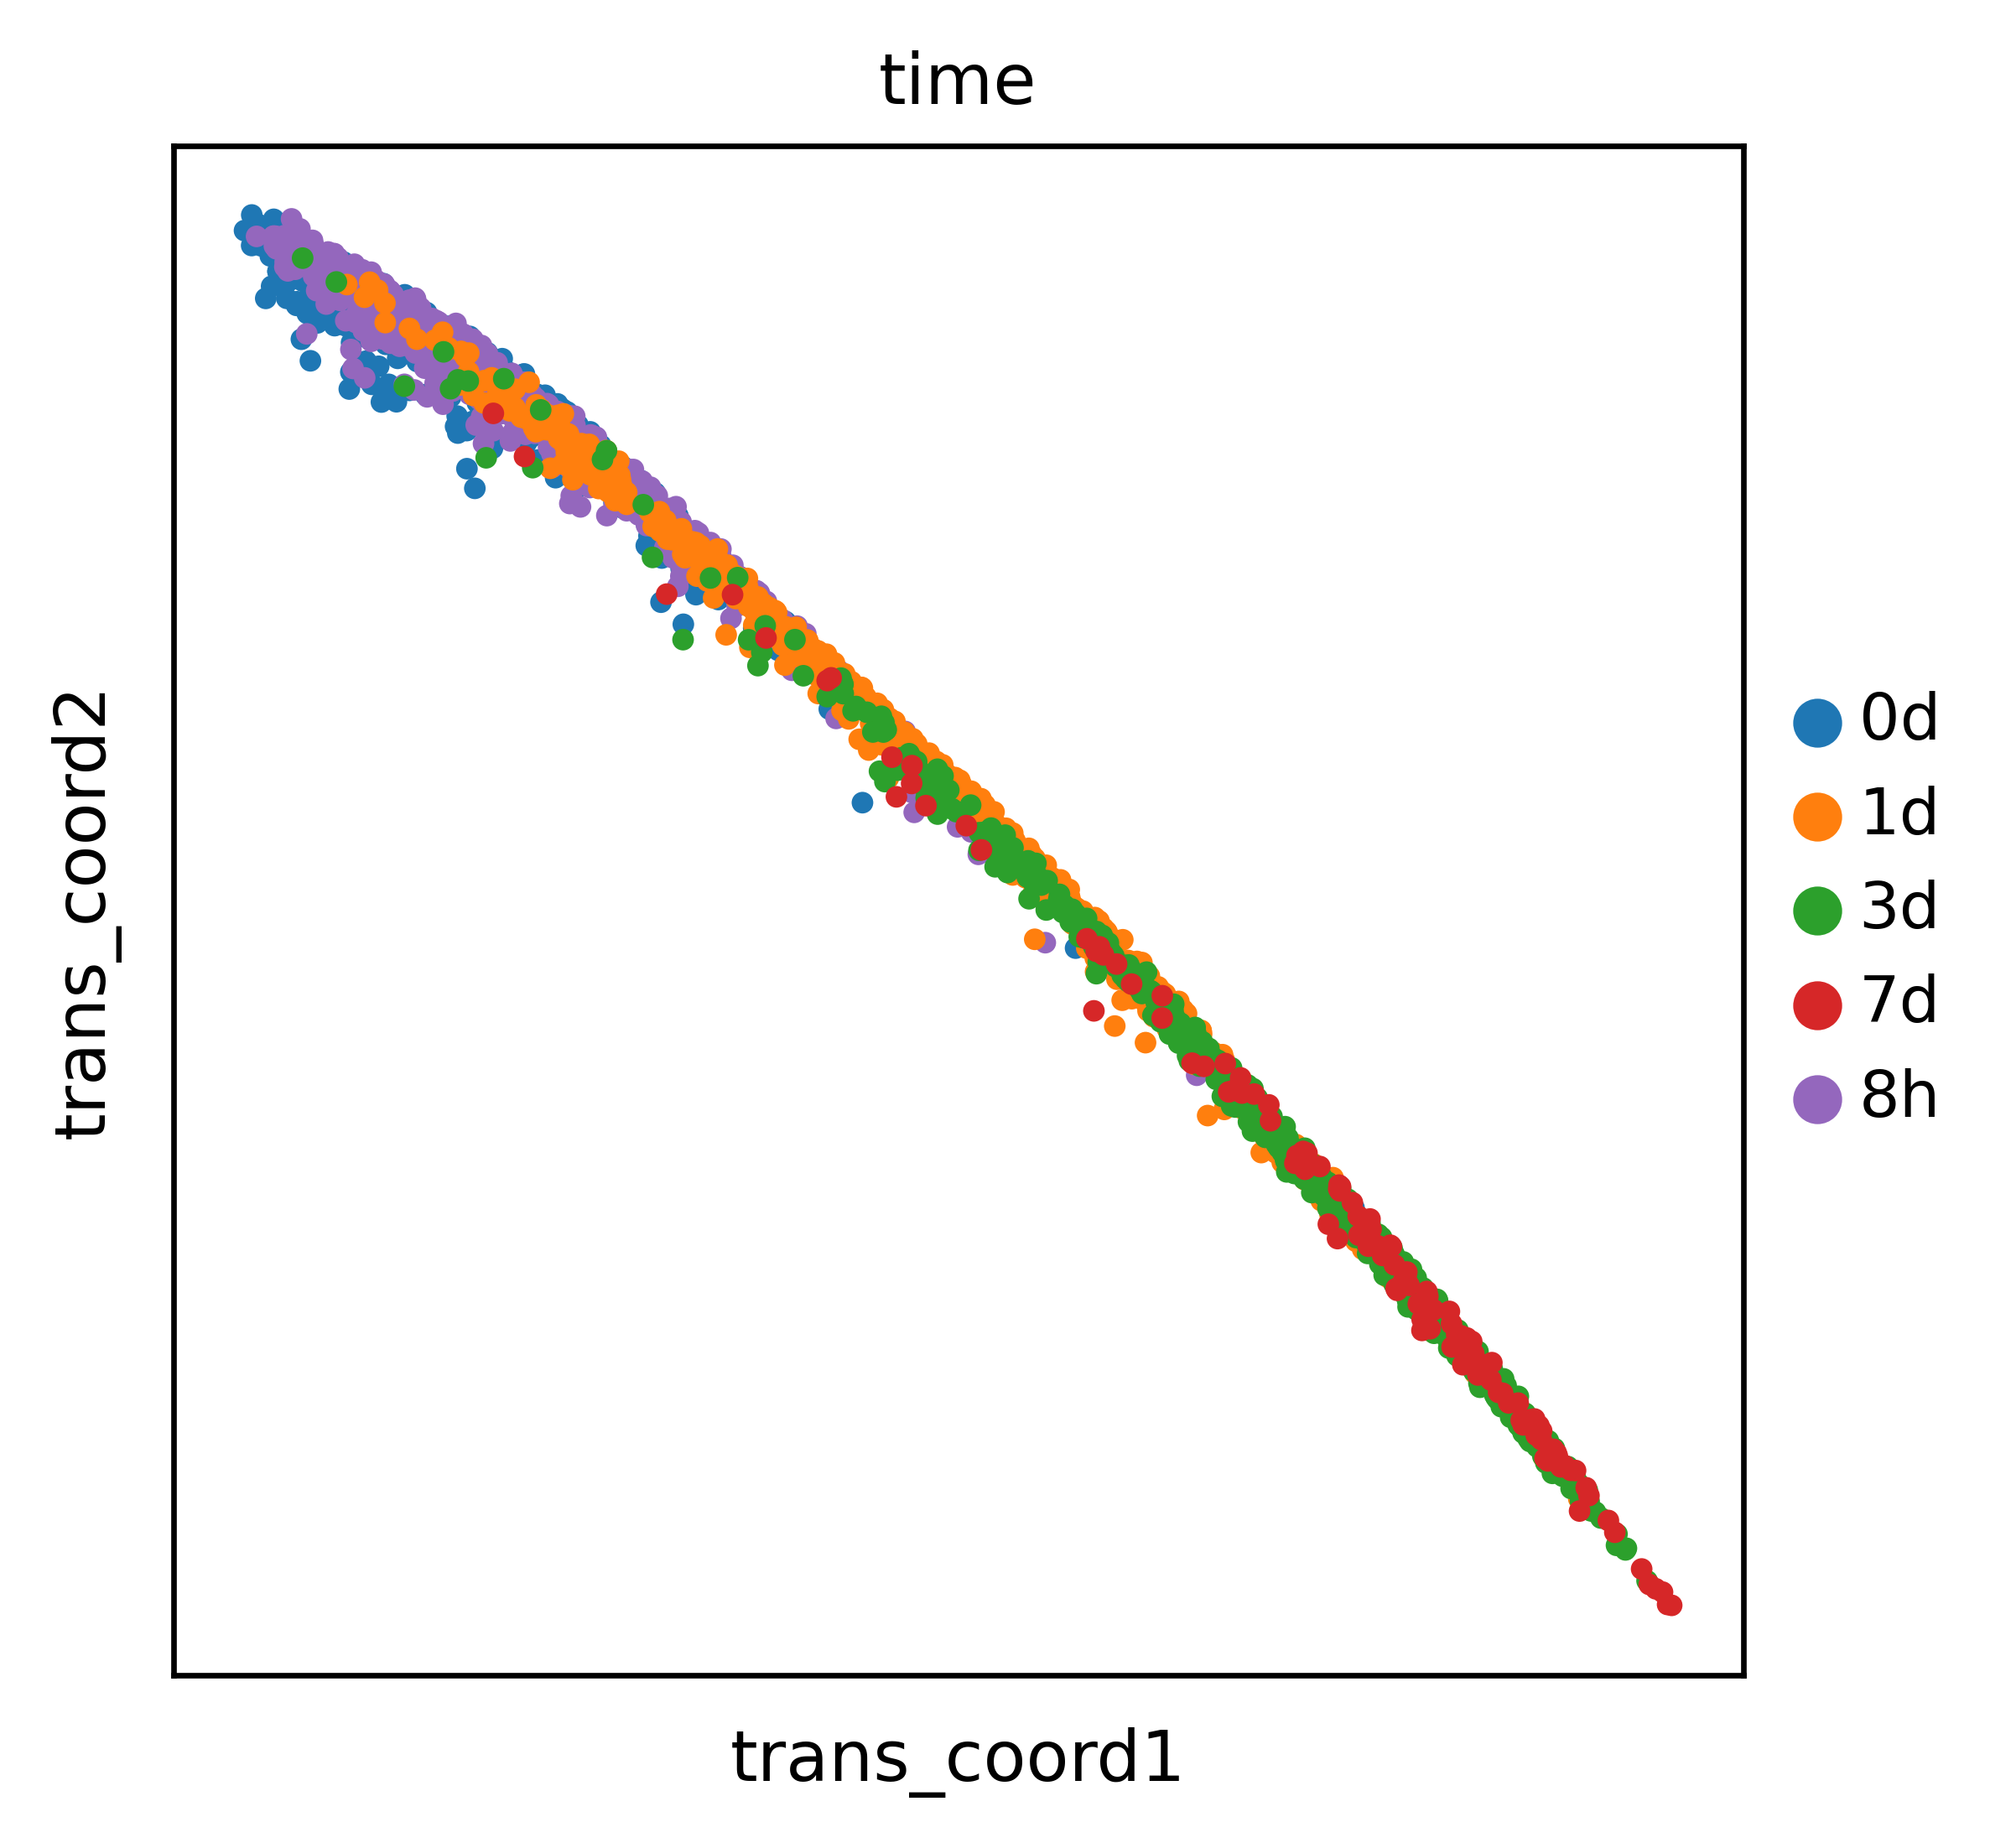

In [12]:
adata.obsm['trans_coord'] = adata.uns['land_out']['trans_coord']
sc.pl.embedding(adata,color = ['time'],basis = 'trans_coord')

In [ ]:
sc.set_figure_params(dpi=600,fontsize = 10)
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['axes.grid'] = False
adata.obsm['X_umap_aggr']=adata_aggr.obsm['X_umap']
st.pl.plot_tensor(adata, adata_aggr,  basis = 'umap',filter_cells = True, member_thresh = 0.2)
plt.savefig('emt_tensor.png')

check that the input includes aggregated object
computing velocity graph (using 16/16 cores)


  0%|          | 0/3132 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


    finished (0:00:03) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vj_umap', embedded velocity vectors (adata.obsm)
check that the input includes aggregated object
computing velocity graph (using 16/16 cores)


  0%|          | 0/3132 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
/home/

    finished (0:00:03) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vj_umap', embedded velocity vectors (adata.obsm)
check that the input includes aggregated object
computing velocity graph (using 16/16 cores)


  0%|          | 0/3132 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
/home/

    finished (0:00:03) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vj_umap', embedded velocity vectors (adata.obsm)
check that the input includes aggregated object
computing velocity graph (using 16/16 cores)


  0%|          | 0/3132 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


    finished (0:00:03) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vj_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 16/16 cores)


  0%|          | 0/3132 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


    finished (0:00:05) --> added 
    'vs_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vs_umap_aggr', embedded velocity vectors (adata.obsm)
computing velocity graph (using 16/16 cores)


  0%|          | 0/3132 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


    finished (0:00:04) --> added 
    'vs_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vs_umap_aggr', embedded velocity vectors (adata.obsm)
computing velocity graph (using 16/16 cores)


  0%|          | 0/3132 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:05) --> added 
    'vs_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vs_umap_aggr', embedded velocity vectors (adata.obsm)
computing velocity graph (using 16/16 cores)


  0%|          | 0/3132 [00:00<?, ?cells/s]

/home/bingsanyu/miniconda3/envs/stt/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://www.mcs.anl.gov/petsc/documentation/faq.html#valgrind
[0]PETSC ERROR: or try http://valgrind.org on GNU/linux and Apple Mac OS X to find memory corruption errors
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


    finished (0:00:05) --> added 
    'vs_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vs_umap_aggr', embedded velocity vectors (adata.obsm)
computing velocity graph (using 16/16 cores)


  0%|          | 0/3132 [00:00<?, ?cells/s]

In [ ]:
sc.set_figure_params(dpi=600,fontsize = 12)
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
st.plot_tensor_single(adata, adata_aggr,  basis = 'umap', state = 'joint',attractor = 2,filter_cells = True, member_thresh = 0.2)

In [ ]:
st.plot_tensor_single(adata, adata_aggr,  basis = 'umap', state = 'joint',attractor = 1,filter_cells = True, member_thresh = 0.2)

In [10]:
st.plot_tensor_single(adata, adata_aggr,  basis = 'umap', state = 'unspliced',attractor = 1,filter_cells = True, member_thresh = 0.2)

AttributeError: module 'stt' has no attribute 'plot_tensor_single'

In [ ]:
st.plot_tensor_single(adata, adata_aggr,  basis = 'umap', state = 'unspliced',attractor = 2,filter_cells = True, member_thresh = 0.2)

In [ ]:
st.plot_tensor_single(adata, adata_aggr,  basis = 'umap', state = 'joint',attractor = None,filter_cells = True, member_thresh = 0.2)

In [ ]:
import seaborn as sns
sns.set(font_scale=2)
sc.pl.violin(adata, keys = ['entropy'], groupby='attractor',xlabel_fontsize=100, ylabel_fontsize=18)

In [ ]:
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
st.pl.plot_genes_list(adata,['FOXP1','FTL','TGFBI'],ncols = 3,figsize = (8,2))

In [ ]:
kernel.adata

In [ ]:
kernel = adata.uns['kernel']
kernel.adata.obsm['X_umap'] = adata_aggr.obsm['X_umap']
kernel.plot_random_walks(n_sims=4,basis='umap',n_jobs=-1)

In [ ]:
import cellrank as cr
g = cr.tl.estimators.GPCCA(kernel)

In [ ]:
dir(g)

In [ ]:
g.fit(cluster_key="attractor",n_lineages = 3)
g.plot_macrostates(which="terminal", legend_loc="right", size=100)

In [ ]:
g.compute_absorption_probabilities()
g.plot_absorption_probabilities(same_plot=False)

In [ ]:
sc.pl.umap(adata_aggr,color = ['attractor','speed','entropy','time'])

In [ ]:
sc.pl.violin(adata, keys = ['FTL','GPX2','CD44','VIM'], groupby='attractor')

## Downstream Analysis

In [1]:
import stt as st
import scanpy as sc
import anndata
import scvelo as scv
adata=sc.read_h5ad('adata_emt_results.h5ad')
adata_aggr=sc.read_h5ad('adata_aggr_emt_results.h5ad')

/Users/cliffzhou/anaconda3/envs/stt/lib/python3.7/site-packages/pyemma/__init__.py:92: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.7, you have 2.5.6.
  .format(latest=latest, current=current), category=UserWarning)


In [ ]:
sc.tl.rank_genes_groups(adata, 'attractor',  method='wilcoxon',key_added = 'de_genes')

In [ ]:
import matplotlib.pyplot as plt

# Set global font size
plt.rcParams.update({'font.size': 18})  # You can adjust the size as needed
sc.pl.rank_genes_groups(adata,key='de_genes', n_genes=25, sharey=False)

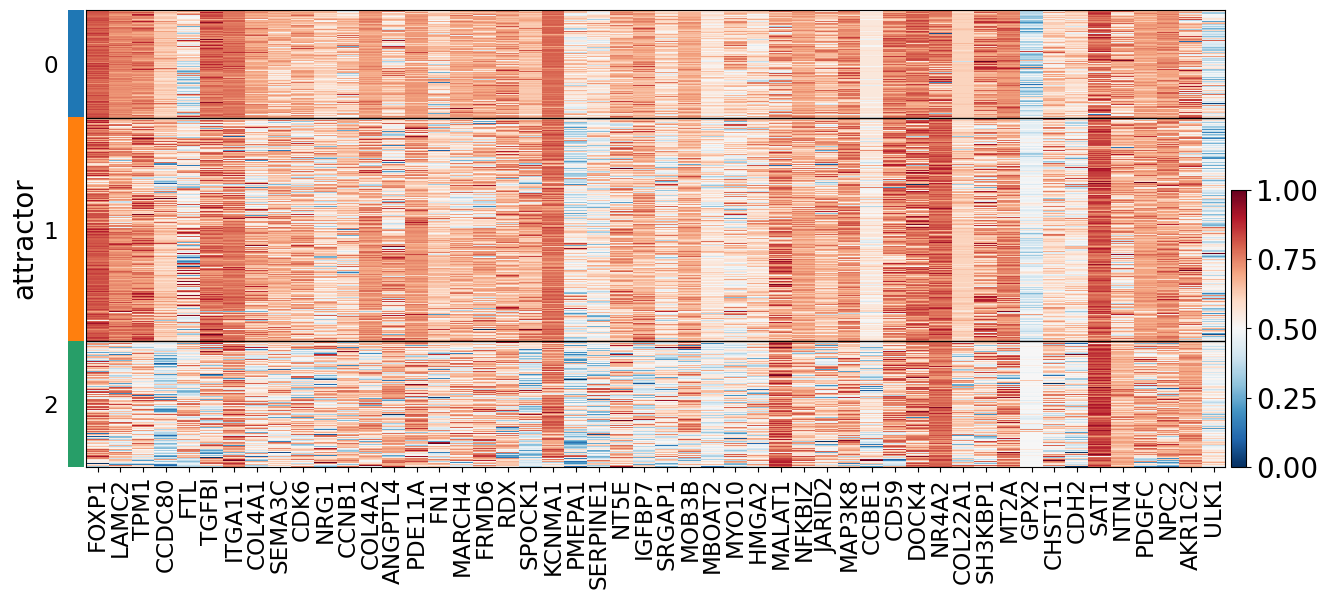

<Figure size 640x480 with 0 Axes>

In [8]:
plt.rcParams.update({'font.size': 20})  # You can adjust the size as needed

st.pl.plot_tensor_heatmap(adata, attractor ='all', component ='spliced')

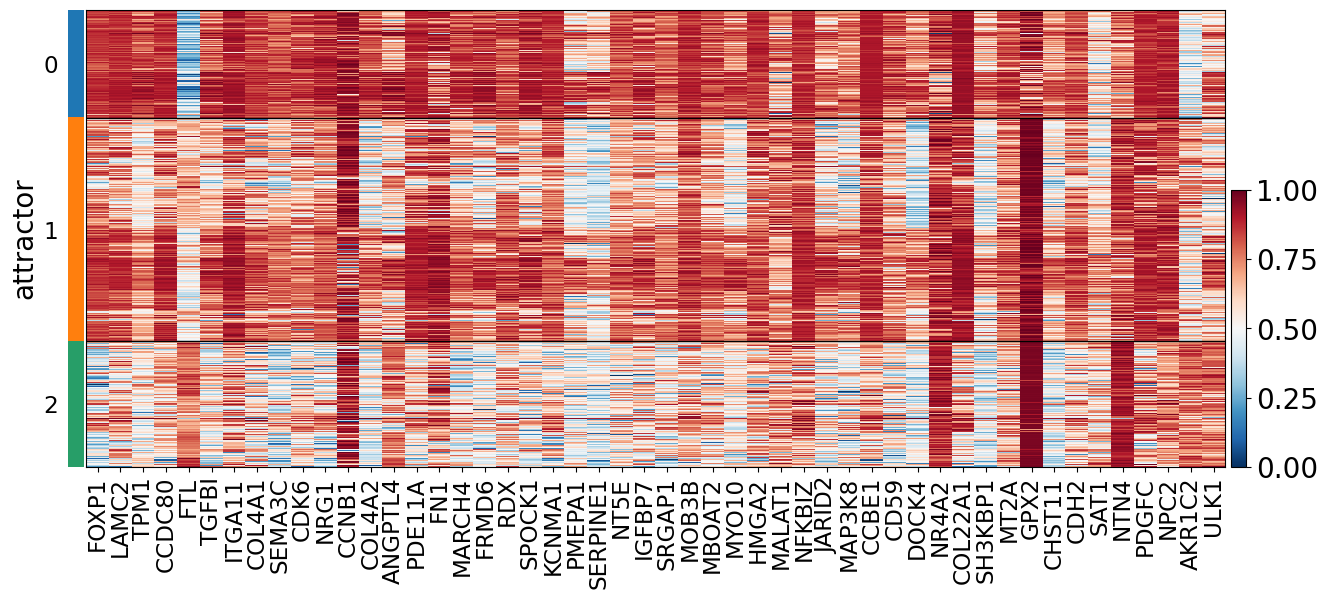

<Figure size 640x480 with 0 Axes>

In [9]:
st.pl.plot_tensor_heatmap(adata, attractor ='all', component ='unspliced')

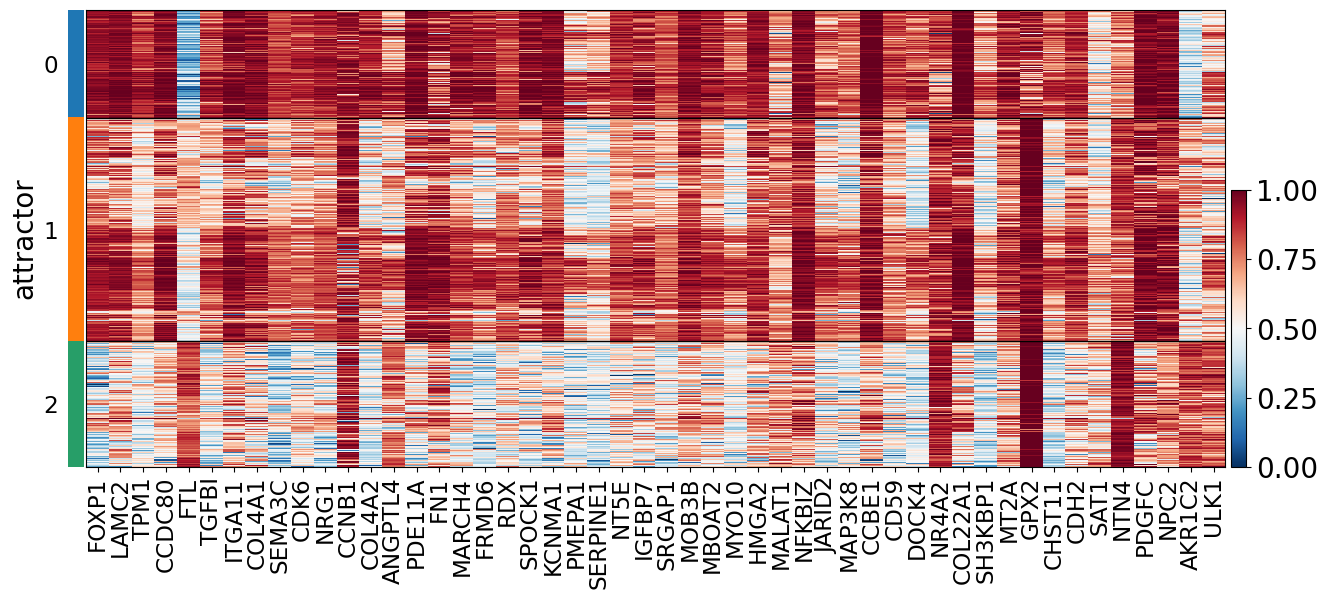

<Figure size 640x480 with 0 Axes>

In [44]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})  # You can adjust the size as needed
st.pl.plot_tensor_heatmap(adata, attractor =0, component ='unspliced')

In [43]:
adata.obsm['tensor_v'][:,:,0,2]-adata.obsm['tensor_v'][:,:,0,0]

array([[ 0.00665969, -1.75068056,  0.03406503, ..., -0.07180212,
         0.01069341,  0.02347723],
       [ 0.00665969, -1.75068056,  0.03406503, ..., -0.07180212,
         0.01069341,  0.02347723],
       [ 0.00665969, -1.75068056,  0.03406503, ..., -0.07180212,
         0.01069341,  0.02347723],
       ...,
       [ 0.00665969, -1.75068056,  0.03406503, ..., -0.07180212,
         0.01069341,  0.02347723],
       [ 0.00665969, -1.75068056,  0.03406503, ..., -0.07180212,
         0.01069341,  0.02347723],
       [ 0.00665969, -1.75068056,  0.03406503, ..., -0.07180212,
         0.01069341,  0.02347723]])

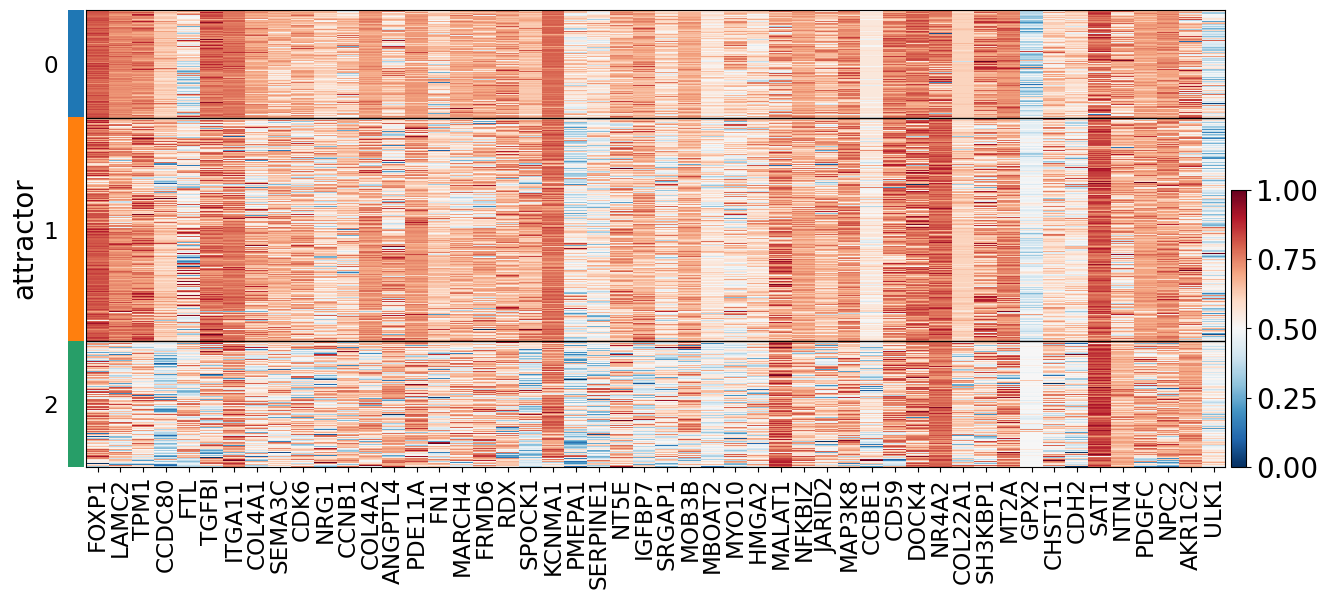

<Figure size 640x480 with 0 Axes>

In [8]:
st.pl.plot_tensor_heatmap(adata, attractor =1, component ='spliced')

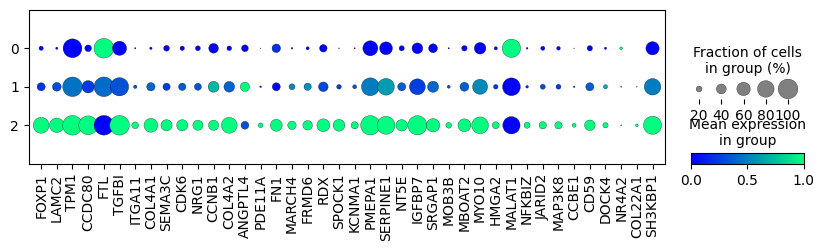

In [5]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})  # You can adjust the size as needed
gene_sort = adata.var['r2_test'].sort_values(ascending=False).index.tolist()
sc.pl.DotPlot(adata, gene_sort[0:40], groupby='attractor',figsize = (10,2),layer = 'spliced',standard_scale = 'var').show()

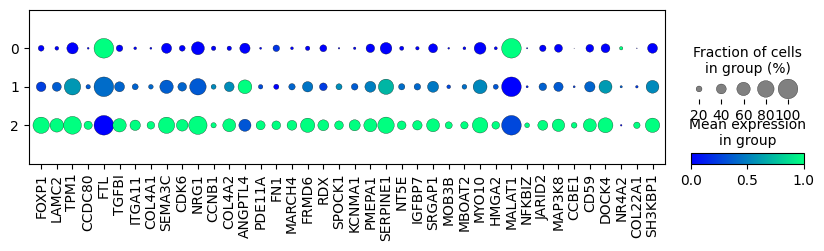

In [6]:
sc.pl.DotPlot(adata, gene_sort[0:40], groupby='attractor',figsize = (10,2),layer = 'unspliced', standard_scale = 'var').show()

In [ ]:
adata.obsm['tensor_v_aver'].shape

In [ ]:
attr = 0
velo_plot = adata.obsm['tensor_v'][:,:,0,attr]
adata.layers['velo_plot'] = velo_plot
sc.pl.heatmap(adata, gene_sort[0:40], groupby='attractor', layer = 'velo_plot',standard_scale = 'var',cmap='RdBu_r')

In [ ]:
st.plot_para_hist(adata,figsize=(8,2))

In [ ]:
#del adata.uns['r2_keep_train']
#del adata.uns['r2_keep_test']
#del adata.uns['kernel_connectivities']
del adata.uns['kernel']
adata.write('adata_emt_results.h5ad')
adata_aggr.write('adata_aggr_emt_results.h5ad')